In [24]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt


In [25]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"


In [26]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0

    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness


In [27]:
def createRoute(cityList):
    route=random.sample(cityList[1:], len(cityList)-1)
    route.insert(0, cityList[0])
    # route = random.sample(cityList, len(cityList))
    return route


In [28]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population


In [29]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0, len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key=operator.itemgetter(1), reverse=True)


In [30]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index", "Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i, 3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults


In [31]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool


In [32]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child


In [33]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0, eliteSize):
        children.append(matingpool[i])

    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children


In [34]:
def mutate(individual):
    best = individual
    improved = True
    n = len(individual)
    while improved:
            improved = False
            for i in range(1, n-1):
                for j in range(i+1, n-1):
                    if j-i == 1:
                        continue
                    new_individual = individual[:]
                    # this is the 2woptSwap
                    new_individual[i:j] = individual[j-1:i-1:-1]
                    if Fitness(new_individual).routeDistance() < Fitness(best).routeDistance():
                        best = new_individual
                        improved = True
    individual = best
    return best


In [35]:
def mutatePopulation(population):
    mutatedPop = []

    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind])
        mutatedPop.append(mutatedInd)
    return mutatedPop


In [36]:
def nextGeneration(currentGen, eliteSize):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children)
    return nextGeneration


In [37]:
def geneticAlgorithm(population, popSize, eliteSize, generations):
    pop = initialPopulation(popSize, population)
    progress = []

    distance = (1 / rankRoutes(pop)[0][1])
    progress.append(distance)
    print(f"Initial distance:   {distance}")
    
    # Best first route
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    # print(bestRoute)
    plotRoute(bestRoute, "Best Initial Route")




    for i in range(0, generations):
        print(f"Current gen {i}")
        pop = nextGeneration(pop, eliteSize)
        progress.append(1 / rankRoutes(pop)[0][1])
        print(f"current best : {1 / rankRoutes(pop)[0][1]}")


    # Best final route.
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]

    plotRoute(bestRoute, "Best Found Route")


    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

    return bestRoute




In [38]:
def plotRoute(bestRoute, title=""):
    bestRoute.append(bestRoute[0])
    bestRoute = np.array([list([i.x, i.y])for i in bestRoute])

    # plot best initial route
    plt.plot(bestRoute[:,0], bestRoute[:,1], marker='o')
    plt.title(title)
    plt.show()

## Prueba con datos aleatorios

Se agregan 50 objetos City a la lista de ciudades. Y posteriormente se invoca la función del algoritmo genético. 

In [39]:
cityList = []

for i in range(0, 50):
    cityList.append(City(x=int(random.random() * 200),
                    y=int(random.random() * 200)))


Initial distance:   4657.51498679177


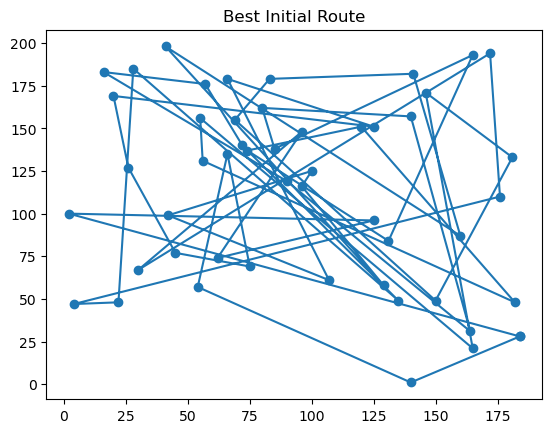

Current gen 0
current best : 4348.309967464368
Current gen 1
current best : 4066.366960173391
Current gen 2
current best : 3837.091573982694
Current gen 3
current best : 3582.8533125577237
Current gen 4
current best : 3412.957275084245
Current gen 5
current best : 3245.2831598243865
Current gen 6
current best : 2871.2410011522256
Current gen 7
current best : 2745.5409182903118
Current gen 8
current best : 2620.2907570094353
Current gen 9
current best : 2521.4845153776528
Current gen 10
current best : 2415.5875898412414
Current gen 11
current best : 2317.9484047502947
Current gen 12
current best : 2216.692867031205
Current gen 13
current best : 2127.055636663935
Current gen 14
current best : 2044.5057693167996
Current gen 15
current best : 1955.76097656923
Current gen 16
current best : 1872.308631416297
Current gen 17
current best : 1789.9023783227576
Current gen 18
current best : 1729.8520644297691
Current gen 19
current best : 1658.300059268562
Current gen 20
current best : 1603.47385

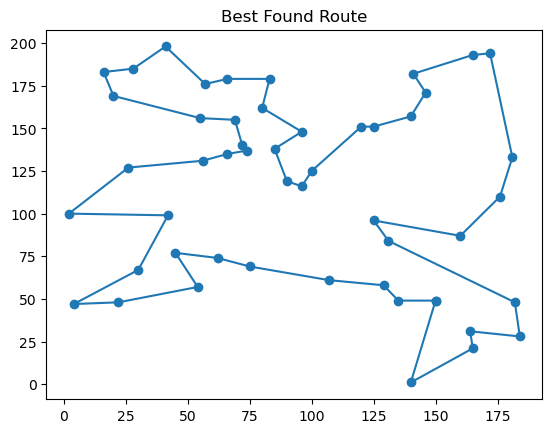

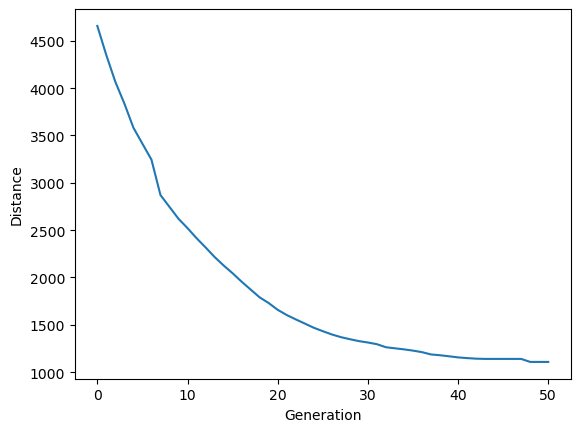

[(150,49),
 (135,49),
 (129,58),
 (107,61),
 (75,69),
 (62,74),
 (45,77),
 (54,57),
 (22,48),
 (4,47),
 (30,67),
 (42,99),
 (2,100),
 (26,127),
 (56,131),
 (66,135),
 (74,137),
 (72,140),
 (69,155),
 (55,156),
 (20,169),
 (16,183),
 (28,185),
 (41,198),
 (57,176),
 (66,179),
 (83,179),
 (80,162),
 (96,148),
 (85,138),
 (90,119),
 (96,116),
 (100,125),
 (120,151),
 (125,151),
 (140,157),
 (146,171),
 (141,182),
 (165,193),
 (172,194),
 (181,133),
 (176,110),
 (160,87),
 (125,96),
 (131,84),
 (182,48),
 (184,28),
 (164,31),
 (165,21),
 (140,1),
 (150,49)]

In [40]:
geneticAlgorithm(population=cityList, popSize=10,
                 eliteSize=5, generations=50)


# Benchmark Kroa 100
A continuación se cargan utilizando el paquete de pandas los datos del benchmark del agente viajero "Kroa100"

In [41]:
data = pd.read_csv('kroA100.tsp', skiprows=[0, 1, 2, 3, 4, 5],
                   header=None, sep=' ')[:-1]
tour = pd.read_csv('kroA100.opt.tour', skiprows=[0, 1, 2, 3, 4],
                   header=None, sep=' ')[:-1]


In [52]:
data=data.rename(columns={0:"ID",1:"x",2:"y"})
dx=data.x.values[[int(i)-1 for i in tour[0].values]]
dy=data.y.values[[int(i)-1 for i in tour[0].values]]



Text(0.5, 1.0, "Benchmark's Best Route")

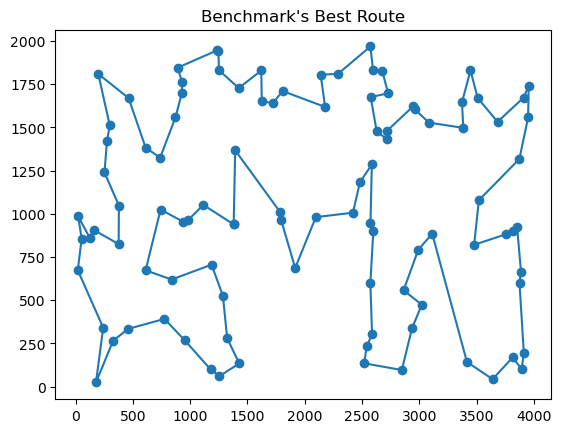

In [55]:
plt.plot(dx,dy, marker='o')
plt.title("Benchmark's Best Route")

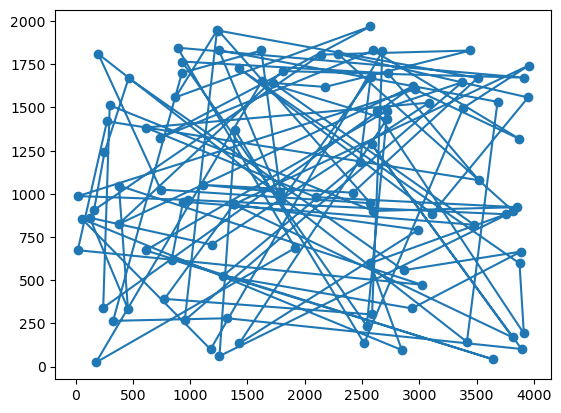

In [60]:
cityList = [] 
for i in range (len (data.x.values)):
    cityList.append(City(data.x[i], data.y[i]))
ruta = createRoute(cityList)


Initial distance:   162079.66228568368


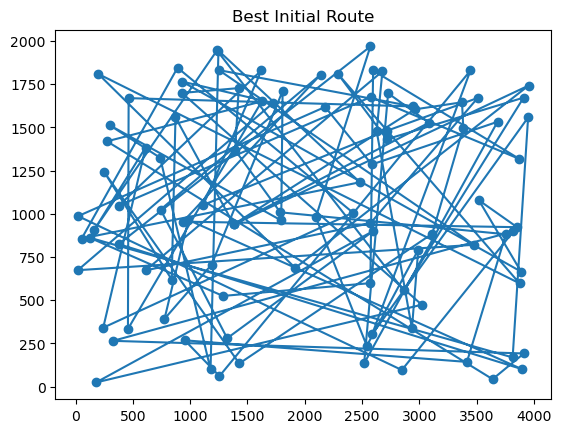

Current gen 0
current best : 155480.128631427
Current gen 1
current best : 147295.70873319148
Current gen 2
current best : 142363.0765710187
Current gen 3
current best : 137474.43981404242
Current gen 4
current best : 132502.28878261248
Current gen 5
current best : 127881.72960611165
Current gen 6
current best : 122602.6065101735
Current gen 7
current best : 115683.3378859532
Current gen 8
current best : 111352.08852739641
Current gen 9
current best : 107494.20612126461
Current gen 10
current best : 103748.58876863601
Current gen 11
current best : 99923.12874420502
Current gen 12
current best : 96453.32013535839
Current gen 13
current best : 92881.78995661701
Current gen 14
current best : 89957.23318401045
Current gen 15
current best : 86304.44420603082
Current gen 16
current best : 83589.82797131463
Current gen 17
current best : 80704.04720434554
Current gen 18
current best : 77707.8857585546
Current gen 19
current best : 75283.88621022455
Current gen 20
current best : 72994.283211161

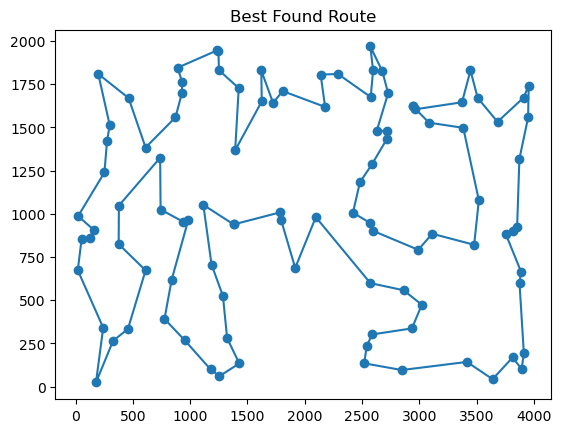

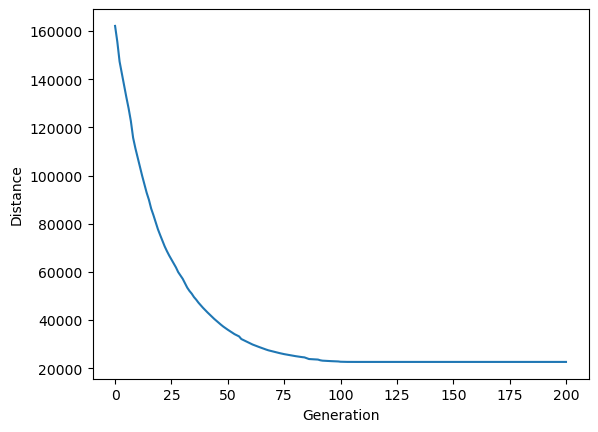

[(2945.0,1622.0),
 (3085.0,1528.0),
 (3384.0,1498.0),
 (3520.0,1079.0),
 (3479.0,821.0),
 (3113.0,885.0),
 (2991.0,792.0),
 (2599.0,901.0),
 (2574.0,946.0),
 (2421.0,1007.0),
 (2482.0,1183.0),
 (2586.0,1286.0),
 (2716.0,1432.0),
 (2721.0,1482.0),
 (2628.0,1479.0),
 (2728.0,1698.0),
 (2678.0,1825.0),
 (2573.0,1969.0),
 (2597.0,1830.0),
 (2576.0,1676.0),
 (2290.0,1810.0),
 (2139.0,1806.0),
 (2178.0,1619.0),
 (1807.0,1711.0),
 (1724.0,1642.0),
 (1621.0,1830.0),
 (1625.0,1651.0),
 (1393.0,1368.0),
 (1424.0,1728.0),
 (1251.0,1832.0),
 (1247.0,1945.0),
 (1234.0,1946.0),
 (890.0,1846.0),
 (929.0,1766.0),
 (928.0,1700.0),
 (872.0,1559.0),
 (611.0,1384.0),
 (463.0,1670.0),
 (198.0,1810.0),
 (298.0,1513.0),
 (274.0,1420.0),
 (252.0,1240.0),
 (22.0,987.0),
 (161.0,906.0),
 (123.0,862.0),
 (53.0,857.0),
 (19.0,674.0),
 (241.0,341.0),
 (178.0,24.0),
 (327.0,265.0),
 (457.0,334.0),
 (611.0,673.0),
 (376.0,825.0),
 (378.0,1048.0),
 (738.0,1325.0),
 (742.0,1025.0),
 (938.0,955.0),
 (984.0,965.0),
 (83

In [61]:
geneticAlgorithm(population=cityList, popSize=10,
                 eliteSize=5, generations=200)